## Общие преобразования

Класс для общих случаев

In [1]:
class InsDataFrame:


    ''' Load data method '''

    def load_pd(self, pd_dataframe):
        self._df = pd_dataframe


    ''' Columns match method '''

    def columns_match(self, match_from_to):
        self._df.rename(columns=match_from_to, inplace=True)


    ''' Person data methods '''

    # Gender
    _gender_dict = {'Male':0, 'Female':1}

    def transform_gender(self):
        self._df['Gender'] = self._df['Gender'].map(self._gender_dict)

        

    # Age
    @staticmethod
    def _age(age, age_max):
        if pd.isnull(age):
            age = None
        elif age < 18:
            age = None
        elif age > age_max:
            age = age_max
        return age
      
    def transform_age(self, age_max=70):
        self._df['driver_minage'] = self._df['driver_minage'].apply(self._age, args=(age_max,))

    # Age M/F
    @staticmethod
    def _age_gender(age_gender):
        _age = age_gender[0]
        _gender = age_gender[1]
        if _gender == 0: #Male
            _driver_minage_m = _age
            _driver_minage_f = 18
        elif _gender == 1: #Female
            _driver_minage_m = 18
            _driver_minage_f = _age
        else:
            _driver_minage_m = 18
            _driver_minage_f = 18
        return [_driver_minage_m, _driver_minage_f]
    
    def transform_age_gender(self):
        self._df['driver_minage_m'],self._df['driver_minage_f'] = zip(*self._df[['driver_minage','Gender']].apply(self._age_gender, axis=1).to_frame()[0])

    # Experience
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        elif exp > exp_max:
            exp = exp_max
        return exp

    def transform_exp(self, exp_max=52):
        self._df['driver_minexp'] = self._df['driver_minexp'].apply(self._exp, args=(exp_max,))


    ''' Other data methods '''

    def polynomizer(self, column, n=2):
        if column in list(self._df.columns):
            for i in range(2,n+1):
                self._df[column+'_'+str(i)] = self._df[column]**i

    def get_dummies(self, columns):
        self._df = pd.get_dummies(self._df, columns=columns)


    ''' General methods '''

    def info(self):
        return self._df.info()

    def head(self, columns, n=5):
        return self._df.head(n)

    def len(self):
        return len(self._df)

    def get_pd(self, columns):
        return self._df[columns]

Создаем класс-наследник, в котором переопределяем некоторые методы, специфические для конкретной ситуации, и создаем новые

- В данных стаж "LicAge" измеряется в неделях.
- Фактор "SocioCateg" содержит информацию о социальной категории в виде кодов классификации CSP. Агрегируем имеющиеся коды до 1 знака, а затем закодируем их с помощью one-hot encoding.

[Wiki](https://fr.wikipedia.org/wiki/Professions_et_cat%C3%A9gories_socioprofessionnelles_en_France#Cr%C3%A9ation_de_la_nomenclature_des_PCS)

[Более подробный классификатор](https://www.ast74.fr/upload/administratif/liste-des-codes-csp-copie.pdf)

In [2]:
class InsDataFrame_Fr(InsDataFrame):

    # Experience (weeks to years)
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        else:
            exp * 7 // 365
        if exp > exp_max:
            exp = exp_max
        return exp

    # Marital status
    _MariStat_dict = {'Other':0, 'Alone':1}

    def transform_MariStat(self):
        self._df['MariStat'] = self._df['MariStat'].map(self._MariStat_dict)
    
    # Social category
    def transform_SocioCateg(self):
        self._df['SocioCateg'] = self._df['SocioCateg'].str.slice(0,4)

### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается взглянуть на задачу моделирования количества страховых случаев как на задачу многоклассовой классификации.

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval, fmin, Trials, STATUS_OK
from functools import partial

#from insolver import InsDataFrame, InsolverGradientBoostingWrapper, train_val_test_split

In [4]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [5]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

Предобработайте данные

In [6]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

df.loc[df.ClaimsCount > 0, 'AvgClaim'] = df['ClaimAmount']/df['ClaimsCount']

data = InsDataFrame_Fr()
data.load_pd(df)
# Переименовываем
data.columns_match({'DrivAge':'driver_minage','LicAge':'driver_minexp'})
# Преобразовываем
data.transform_age()
data.transform_exp()
data.transform_gender()
data.transform_MariStat()
data.transform_SocioCateg()
# Пересечение пола и возраста, их квадраты
data.transform_age_gender()
data.polynomizer('driver_minage_m')
data.polynomizer('driver_minage_f')
# Onehot encoding
data.get_dummies(['VehUsage','SocioCateg'])

col_features = [
                'driver_minexp',
                'Gender',
                'MariStat',
                'HasKmLimit',
                'BonusMalus',
                'OutUseNb',
                'RiskArea',
                'driver_minage_m',
                'driver_minage_f',
                'driver_minage_m_2',
                'driver_minage_f_2',
                'VehUsage_Private',
                'VehUsage_Private+trip to office',
                'VehUsage_Professional',
                'VehUsage_Professional run',
                'SocioCateg_CSP1',
                'SocioCateg_CSP2',
                'SocioCateg_CSP3',
                'SocioCateg_CSP4',
                'SocioCateg_CSP5',
                'SocioCateg_CSP6',
                'SocioCateg_CSP7'  
]

col_target = ['ClaimAmount', 'ClaimsCount', 'AvgClaim']

df = data.get_pd(col_features+col_target)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   driver_minexp                    115155 non-null  int64  
 1   Gender                           115155 non-null  int64  
 2   MariStat                         115155 non-null  int64  
 3   HasKmLimit                       115155 non-null  int64  
 4   BonusMalus                       115155 non-null  int64  
 5   OutUseNb                         115155 non-null  float64
 6   RiskArea                         115155 non-null  float64
 7   driver_minage_m                  115155 non-null  int64  
 8   driver_minage_f                  115155 non-null  int64  
 9   driver_minage_m_2                115155 non-null  int64  
 10  driver_minage_f_2                115155 non-null  int64  
 11  VehUsage_Private                 115155 non-null  uint8  
 12  Ve

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [8]:
df.loc[df['ClaimsCount'] == 11, 'ClaimsCount'] = 10
df['ClaimsCount'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0.0     104286
2.0       3529
1.0       3339
3.0       2310
4.0       1101
5.0        428
6.0        127
7.0         26
8.0          6
9.0          2
10.0         1
Name: ClaimsCount, dtype: int64

Посмотрим, сколько полисов соответствуют каждому из значений `ClaimsCount`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [9]:
FreqCount = pd.DataFrame(df.groupby('ClaimsCount').size(), columns=['Count'])
FreqCount['Freq'] = (FreqCount['Count'] - FreqCount['Count'].min()) / (FreqCount['Count'].max() - FreqCount['Count'].min())
FreqCount.head()

,Count,Freq
ClaimsCount,,
0.0,104286,1.000000
1.0,3339,0.032008
2.0,3529,0.033830
3.0,2310,0.022141
4.0,1101,0.010548


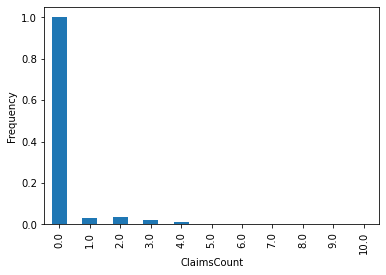

In [10]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [11]:
FreqCount

,Count,Freq
ClaimsCount,,
0.0,104286,1.000000
1.0,3339,0.032008
2.0,3529,0.033830
3.0,2310,0.022141
4.0,1101,0.010548
5.0,428,0.004095
6.0,127,0.001208
7.0,26,0.000240
8.0,6,0.000048


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.05` для значений `ClaimsCount` 0, а для остальных - 1 (Для этого можем использовать функцию `np.where`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [12]:
df['weight'] = 0
df.loc[df['ClaimAmount'] == 0, 'weight'] = 0.05
df.loc[df['ClaimAmount'] != 0, 'weight'] = 1
df['weight'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0.05    104286
1.00     10869
Name: weight, dtype: int64

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df[col_features], df.ClaimsCount, test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

In [14]:
train_indexes = x_train.index

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [15]:
xgb_train = xgb.DMatrix(x_train, y_train, weight=df['weight'][train_indexes])
# в col_features нет этого параметра, т.е., он уже исключен из data
xgb_valid = xgb.DMatrix(x_valid, y_valid)
xgb_test = xgb.DMatrix(x_test, y_test)

Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [16]:
# Зададим функцию Deviance
def xgb_eval_dev_logloss(yhat, y):
    t_hat, t = yhat + 0.1, y.get_label() + 0.1
    err = np.sum(- np.mean(t * np.log(t_hat) + (1.0 - t) * np.log(1.0 - t_hat)))
    return 'dev_logloss', err

In [17]:
# Определим границы, в которых будем искать гиперпараметры
space_xgboost = {'objective': 'multi:softmax',
              'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
              'eta': hp.uniform('eta', 0.01, 1),
              'gamma': hp.uniform('gamma', 0.01, 1000),
              'num_class': 11,
              'tree_method': 'hist'
              }

In [18]:
# Определим параметры выполнения кроссвалидации
cv_params = {'num_boost_round': 1000,
             'nfold': 3,
             'shuffle': True,
             'stratified': False,
             'feval': xgb_eval_dev_logloss,
             'maximize': False,
             'early_stopping_rounds': 20,
              }

In [19]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params, cv_params, data):
    if 'max_depth' in params.keys():
        params['max_depth'] = int(params['max_depth'])
    cv_result = xgb.cv(params=params, dtrain=data, **cv_params)
    name = [i for i in cv_result.columns if all([i.startswith('test-'), i.endswith('-mean')])][-1]
    score = cv_result[name][-1:].values[0]
    return {'loss': score, 'status': STATUS_OK}

In [20]:
# Оптимизация (количество итераций снижено для ускорения работы)
trials = Trials()
best = fmin(fn=partial(objective, cv_params=cv_params, data=xgb_train),
            space=space_xgboost, trials=trials, algo=tpe.suggest, max_evals=50, timeout=3600)

#igb = InsolverGradientBoostingWrapper(algorithm='xgboost')
#igb.hyperopt_cv(x_train.drop('weight', axis=1), y_train, space_xgboost, cv_params,
#                data_params={'weight': x_train['weight']}, max_evals=50)

100%|██████████████████████████████████████████████████████████| 50/50 [04:07<00:00,  4.95s/trial, best loss: 0.801937]


In [21]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_xgboost, best)
best_params

{'alpha': 0.9436846682272054,
 'colsample_bytree': 0.5057351033337292,
 'eta': 0.7291961654871844,
 'gamma': 834.365251962124,
 'lambda': 0.26600747078754905,
 'max_depth': 8,
 'min_child_weight': 36.066276130109614,
 'num_class': 11,
 'objective': 'multi:softmax',
 'subsample': 0.6611520205199156,
 'tree_method': 'hist'}

Далее обучим нашу модель с оптимальными параметрами

In [22]:
train_params = {'num_boost_round': 300,
                'feval': xgb_eval_dev_logloss,
                'maximize': False,
                'verbose_eval': False}

In [33]:
# Построение модели без ранней остановки

progress_multiclass = dict()
xgb_multiclass = xgb.train(params=best_params, dtrain=xgb_train, evals=[(xgb_train, "train"), (xgb_valid, "valid"), (xgb_test, "test")],
                           evals_result=progress_wo_es, **train_params)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [34]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb_multiclass.predict(dfset['dmat']) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.9049101826121477
F1 Score on valid: 0.9077751403925202
F1 Score on test: 0.9067384508509899


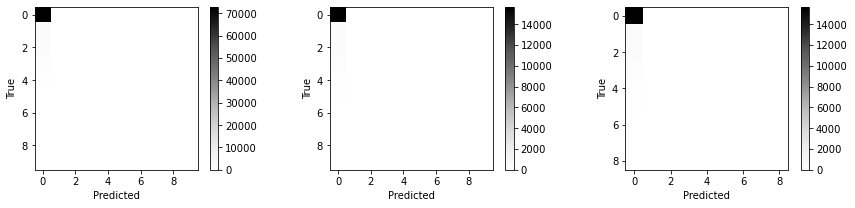

In [35]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_multiclass.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

Результаты f1-метрики довольно высокие. Но видимо, так получилось за счет дисбаланса классов - несмотря на заданные веса, на графиках предсказания сосредоточены в районе нуля. Можно попробовать применить cэмплирование либо использовать алгоритм регрессии.